<h1><a>PD Model</a></h1>

<h2><a id="index">Index</a></h2>

[1. Load Data and Select the Features](#loaddata)

[2. PD Model Estimation](#pdmodel)

[3. PD Model Validation (Test)](#pdmodeltest)

[4. Applying the PD Model](#pdmodelapplication)

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<h2><a id="loaddata">1. Load Data and Select the Features</a></h2>

[Index](#index)

[1.1 Import Data](#importdata)

[1.2 Explore Data](#exploradata)

[1.3 Selecting the Features](#selectfeat)

<h3><a id="importdata">1.1 Import Data</a></h3>

[Top](#loaddata)

In [2]:
loan_data_inputs_train = pd.read_csv('../Data/loan_data_inputs_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('../Data/loan_data_targets_train.csv', index_col = 0)
loan_data_inputs_test = pd.read_csv('../Data/loan_data_inputs_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('../Data/loan_data_targets_test.csv', index_col = 0)

<h3><a id="exploradata">1.2 Explore Data</a></h3>

[Top](#loaddata)

In [3]:
loan_data_inputs_train.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [4]:
loan_data_targets_train.head()

,good_bad
427211,1
206088,1
136020,1
412305,0
36159,0


In [5]:
print(f"Train X Shape: {loan_data_inputs_train.shape}")
print(f"Train y Shape: {loan_data_targets_train.shape}")
print(f"Text X Shape: {loan_data_inputs_test.shape}")
print(f"Text y Shape: {loan_data_targets_test.shape}")

Train X Shape: (373028, 324)
Train y Shape: (373028, 1)
Text X Shape: (93257, 324)
Text y Shape: (93257, 1)


<h3><a id="selectfeat">1.3 Selecting the Features</a></h3>

[Top](#loaddata)

In [6]:
# Here we select a limited set of input variables in a new dataframe.
selected_features = ['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G', 
                     'home_ownership:RENT_OTHER_NONE_ANY', 'home_ownership:OWN', 'home_ownership:MORTGAGE', 
                     'addr_state:ND_NE_IA_NV_FL_HI_AL', 'addr_state:NM_VA', 'addr_state:NY', 
                     'addr_state:OK_TN_MO_LA_MD_NC', 'addr_state:CA', 'addr_state:UT_KY_AZ_NJ', 
                     'addr_state:AR_MI_PA_OH_MN', 'addr_state:RI_MA_DE_SD_IN', 'addr_state:GA_WA_OR', 'addr_state:WI_MT',
                     'addr_state:TX', 'addr_state:IL_CT', 'addr_state:KS_SC_CO_VT_AK_MS', 'addr_state:WV_NH_WY_DC_ME_ID', 
                     'verification_status:Not Verified', 'verification_status:Source Verified', 
                     'verification_status:Verified', 
                     'purpose:educ__sm_b__wedd__ren_en__mov__house', 'purpose:credit_card', 'purpose:debt_consolidation', 
                     'purpose:oth__med__vacation', 'purpose:major_purch__car__home_impr', 
                     'initial_list_status:f', 'initial_list_status:w', 
                     'term:36', 'term:60',
                     'emp_length:0', 'emp_length:1', 'emp_length:2-4', 'emp_length:5-6', 'emp_length:7-9', 
                     'emp_length:10', 
                     'mths_since_issue_d:<38', 'mths_since_issue_d:38-39', 'mths_since_issue_d:40-41', 
                     'mths_since_issue_d:42-48', 'mths_since_issue_d:49-52', 'mths_since_issue_d:53-64', 
                     'mths_since_issue_d:65-84', 'mths_since_issue_d:>84',
                     'int_rate:<9.548', 'int_rate:9.548-12.025', 'int_rate:12.025-15.74', 'int_rate:15.74-20.281', 
                     'int_rate:>20.281',
                     'mths_since_earliest_cr_line:<140', 'mths_since_earliest_cr_line:141-164',
                     'mths_since_earliest_cr_line:165-247', 'mths_since_earliest_cr_line:248-270', 
                     'mths_since_earliest_cr_line:271-352', 'mths_since_earliest_cr_line:>352',
                     'delinq_2yrs:0', 'delinq_2yrs:1-3', 'delinq_2yrs:>=4',
                     'inq_last_6mths:0', 'inq_last_6mths:1-2', 'inq_last_6mths:3-6', 'inq_last_6mths:>6', 
                     'open_acc:0', 'open_acc:1-3', 'open_acc:4-12', 'open_acc:13-17', 'open_acc:18-22', 'open_acc:23-25', 
                     'open_acc:26-30', 'open_acc:>=31', 
                     'pub_rec:0-2', 'pub_rec:3-4', 'pub_rec:>=5',
                     'total_acc:<=27', 'total_acc:28-51', 'total_acc:>=52', 
                     'acc_now_delinq:0', 'acc_now_delinq:>=1', 
                     'total_rev_hi_lim:<=5K', 'total_rev_hi_lim:5K-10K', 'total_rev_hi_lim:10K-20K', 
                     'total_rev_hi_lim:20K-30K', 'total_rev_hi_lim:30K-40K', 'total_rev_hi_lim:40K-55K', 
                     'total_rev_hi_lim:55K-95K', 'total_rev_hi_lim:>95K', 
                     'annual_inc:<20K', 'annual_inc:20K-30K', 'annual_inc:30K-40K', 'annual_inc:40K-50K', 
                     'annual_inc:50K-60K', 'annual_inc:60K-70K', 'annual_inc:70K-80K', 'annual_inc:80K-90K', 
                     'annual_inc:90K-100K', 'annual_inc:100K-120K', 'annual_inc:120K-140K', 'annual_inc:>140K', 
                     'dti:<=1.4', 'dti:1.4-3.5', 'dti:3.5-7.7', 'dti:7.7-10.5', 'dti:10.5-16.1', 'dti:16.1-20.3', 
                     'dti:20.3-21.7', 'dti:21.7-22.4', 'dti:22.4-35', 'dti:>35', 
                     'mths_since_last_delinq:Missing', 'mths_since_last_delinq:0-3', 'mths_since_last_delinq:4-30', 
                     'mths_since_last_delinq:31-56', 'mths_since_last_delinq:>=57', 'mths_since_last_record:Missing', 
                     'mths_since_last_record:0-2', 'mths_since_last_record:3-20', 'mths_since_last_record:21-31', 
                     'mths_since_last_record:32-80',  'mths_since_last_record:81-86', 'mths_since_last_record:>86',]

In [7]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories = ['grade:G', 'home_ownership:RENT_OTHER_NONE_ANY', 'addr_state:ND_NE_IA_NV_FL_HI_AL', 
                  'verification_status:Verified',  'purpose:educ__sm_b__wedd__ren_en__mov__house', 
                  'initial_list_status:f', 'term:60', 'emp_length:0', 'mths_since_issue_d:>84', 
                  'int_rate:>20.281', 'mths_since_earliest_cr_line:<140', 'delinq_2yrs:>=4', 'inq_last_6mths:>6', 
                  'open_acc:0', 'pub_rec:0-2', 'total_acc:<=27', 'acc_now_delinq:0', 'total_rev_hi_lim:<=5K', 
                  'annual_inc:<20K', 'dti:>35', 'mths_since_last_delinq:0-3', 'mths_since_last_record:0-2']

In [8]:
# From the dataframe with input variables, we drop the variables with variable names in the list with reference categories.
loan_data_inputs_train = loan_data_inputs_train[selected_features]
inputs_train = loan_data_inputs_train.drop(ref_categories, axis = 1)
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


<h2><a id="pdmodel">2. PD Model Estimation</a></h2>

[Index](#index)

In [9]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [10]:
# We create an instance of an object from the newly created 'LogisticRegression_with_p_values()' class.
reg = LogisticRegression_with_p_values()

In [11]:
reg.fit(inputs_train, loan_data_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [12]:
# Same as above.
feature_name = inputs_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table.head()

,Feature name,Coefficients
0,Intercept,-1.331127
1,grade:A,1.160111
2,grade:B,0.906062
3,grade:C,0.708869
4,grade:D,0.519064


In [13]:
# Add p-values
p_values = reg.p_values
# Add the intercept for completeness
p_values = np.append(np.nan, np.array(p_values))
summary_table['p_values'] = p_values
summary_table.head()

,Feature name,Coefficients,p_values
0,Intercept,-1.331127,NaN
1,grade:A,1.160111,1.701206e-37
2,grade:B,0.906062,1.037505e-49
3,grade:C,0.708869,6.538477e-36
4,grade:D,0.519064,4.993963e-22


In [14]:
# We are going to remove some features, the coefficients for all or almost all of the dummy variables for which,
# are not tatistically significant.

# We do that by specifying another list of dummy variables as reference categories, and a list of variables to remove.
# Then, we are going to drop the two datasets from the original list of dummy variables.

# Variables
variables = ['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G', 
             'home_ownership:RENT_OTHER_NONE_ANY', 'home_ownership:OWN', 'home_ownership:MORTGAGE', 
             'addr_state:ND_NE_IA_NV_FL_HI_AL', 'addr_state:NM_VA', 'addr_state:NY', 'addr_state:OK_TN_MO_LA_MD_NC', 
             'addr_state:CA', 'addr_state:UT_KY_AZ_NJ', 'addr_state:AR_MI_PA_OH_MN', 'addr_state:RI_MA_DE_SD_IN', 
             'addr_state:GA_WA_OR', 'addr_state:WI_MT', 'addr_state:TX', 'addr_state:IL_CT', 
             'addr_state:KS_SC_CO_VT_AK_MS', 'addr_state:WV_NH_WY_DC_ME_ID',
             'verification_status:Not Verified', 'verification_status:Source Verified', 'verification_status:Verified',
            'purpose:educ__sm_b__wedd__ren_en__mov__house', 'purpose:credit_card', 'purpose:debt_consolidation', 
             'purpose:oth__med__vacation', 'purpose:major_purch__car__home_impr',
             'initial_list_status:f', 'initial_list_status:w',
             'term:36', 'term:60', 
             'emp_length:0', 'emp_length:1', 'emp_length:2-4', 'emp_length:5-6', 'emp_length:7-9', 'emp_length:10',
             'mths_since_issue_d:<38', 'mths_since_issue_d:38-39', 'mths_since_issue_d:40-41', 
             'mths_since_issue_d:42-48', 'mths_since_issue_d:49-52', 'mths_since_issue_d:53-64', 
             'mths_since_issue_d:65-84', 'mths_since_issue_d:>84', 
             'int_rate:<9.548', 'int_rate:9.548-12.025', 'int_rate:12.025-15.74', 'int_rate:15.74-20.281', 
             'int_rate:>20.281', 
             'mths_since_earliest_cr_line:<140', 'mths_since_earliest_cr_line:141-164', 
             'mths_since_earliest_cr_line:165-247', 'mths_since_earliest_cr_line:248-270', 
             'mths_since_earliest_cr_line:271-352', 'mths_since_earliest_cr_line:>352',
             'inq_last_6mths:0', 'inq_last_6mths:1-2', 'inq_last_6mths:3-6', 'inq_last_6mths:>6', 
             'acc_now_delinq:0', 'acc_now_delinq:>=1', 'annual_inc:<20K', 'annual_inc:20K-30K', 'annual_inc:30K-40K',
             'annual_inc:40K-50K', 'annual_inc:50K-60K', 'annual_inc:60K-70K', 'annual_inc:70K-80K', 'annual_inc:80K-90K',
             'annual_inc:90K-100K', 'annual_inc:100K-120K', 'annual_inc:120K-140K', 'annual_inc:>140K', 
             'dti:<=1.4', 'dti:1.4-3.5', 'dti:3.5-7.7', 'dti:7.7-10.5', 'dti:10.5-16.1', 'dti:16.1-20.3', 'dti:20.3-21.7',
             'dti:21.7-22.4', 'dti:22.4-35', 'dti:>35',
             'mths_since_last_delinq:Missing', 'mths_since_last_delinq:0-3', 'mths_since_last_delinq:4-30', 
             'mths_since_last_delinq:31-56', 'mths_since_last_delinq:>=57', 'mths_since_last_record:Missing', 
             'mths_since_last_record:0-2', 'mths_since_last_record:3-20', 'mths_since_last_record:21-31', 
             'mths_since_last_record:32-80', 'mths_since_last_record:81-86', 'mths_since_last_record:>86'] 


ref_categories = ['grade:G', 'home_ownership:RENT_OTHER_NONE_ANY', 'addr_state:ND_NE_IA_NV_FL_HI_AL', 
                  'verification_status:Verified', 'purpose:educ__sm_b__wedd__ren_en__mov__house', 'initial_list_status:f', 
                  'term:60', 'emp_length:0', 'mths_since_issue_d:>84', 'int_rate:>20.281',
                  'mths_since_earliest_cr_line:<140', 'inq_last_6mths:>6', 'acc_now_delinq:0', 'annual_inc:<20K', 
                  'dti:>35', 'mths_since_last_delinq:0-3', 'mths_since_last_record:0-2']

In [15]:
inputs_train = loan_data_inputs_train[variables]
inputs_train = inputs_train.drop(ref_categories, axis = 1)
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [16]:
# Here we run a new model.
reg2 = LogisticRegression_with_p_values()
reg2.fit(inputs_train, loan_data_targets_train)

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [17]:
# Same as above.
feature_name = inputs_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.374022,NaN
1,grade:A,1.123667,3.224492e-35
2,grade:B,0.878915,4.281595e-47
3,grade:C,0.684794,6.716246e-34
4,grade:D,0.496922,1.347121e-20
...,...,...,...
80,mths_since_last_record:3-20,0.440624,3.347224e-04
81,mths_since_last_record:21-31,0.350706,1.832662e-03
82,mths_since_last_record:32-80,0.502948,3.966441e-09
83,mths_since_last_record:81-86,0.175838,8.604849e-02


In [18]:
# Export our model to a 'SAV' file with file name 'pd_model.sav'.
pickle.dump(reg2, open('../Models//pd_model.sav', 'wb'))

<h2><a id="pdmodeltest">3. PD Model Validation (Test)</a></h2>

[Index](#index)

[3.1 Score Test Data](#pdmodeltestcalculateprob)

[3.2 Accuracy and Area under the Curve](#pdmodeltestauc)

[3.3 Gini and Kolmogorov-Smirnov](#pdmodeltestginiks)

In [19]:
# Here, from the dataframe with inputs for testing, we keep the same variables that we used in our final PD model.
inputs_test = loan_data_inputs_test[variables]
inputs_test = inputs_test.drop(ref_categories, axis = 1)
inputs_test.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
288564,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
213591,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
263083,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
165001,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


<h3><a id="pdmodeltestcalculateprob">3.1 Score Test Data</a></h3>

[Top](#pdmodeltest)

In [20]:
# Calculates the predicted values for the dependent variable (targets)
y_hat_test = reg2.model.predict(inputs_test)
y_hat_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [21]:
# Calculates the predicted probability values for the dependent variable (targets)
y_hat_test_proba = reg2.model.predict_proba(inputs_test)
# Here we take all the arrays in the array, and from each array, we take all rows, and only the element with index 1,
# that is, the second element.
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
y_hat_test_proba

array([0.92430558, 0.84923885, 0.88534875, ..., 0.97321336, 0.95979132,
       0.95236649])

In [22]:
loan_data_targets_test_temp = loan_data_targets_test
# We reset the index of a dataframe.
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)
# Concatenate the two dataframes
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
df_actual_predicted_probs.index = loan_data_inputs_test.index
df_actual_predicted_probs.shape

(93257, 2)

In [23]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba
362514,1,0.924306
288564,1,0.849239
213591,1,0.885349
263083,1,0.940636
165001,1,0.968665


<h3><a id="pdmodeltestauc">3.2 Accuracy and Area under the Curve</a></h3>

[Top](#pdmodeltest)

In [24]:
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
tr = 0.9
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)
# Create a Confusion Matrix
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], 
            rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,7374,2816
1,35813,47254


In [25]:
# Normalized Confusion Matrix
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], 
            rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.079072,0.030196
1,0.384025,0.506707


In [26]:
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
             rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (
    pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
             rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.5857790836076648

In [27]:
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'],
                                 df_actual_predicted_probs['y_hat_test_proba'])

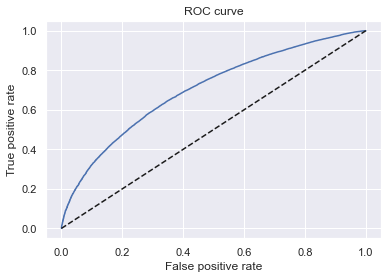

In [28]:
# Plot the ROC Curve
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [29]:
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
AUROC

0.7022081357100709

<h3><a id="pdmodeltestginiks">3.3 Gini and Kolmogorov-Smirnov</a></h3>

[Top](#pdmodeltest)

In [30]:
# Sorts a dataframe by the values of a specific column.
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
# We reset the index of a dataframe and overwrite it.
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,42341,1,0.375286,0
1,42344,1,0.392102,0
2,39810,0,0.393739,0
3,40518,0,0.448969,0
4,42396,0,0.457735,0


In [31]:
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1

# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()

# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.
df_actual_predicted_probs['Cumulative N Bad'] = (df_actual_predicted_probs['Cumulative N Population'] - 
                                                 df_actual_predicted_probs['loan_data_targets_test'].cumsum())
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad
0,42341,1,0.375286,0,1,1,0
1,42344,1,0.392102,0,2,2,0
2,39810,0,0.393739,0,3,2,1
3,40518,0,0.448969,0,4,2,2
4,42396,0,0.457735,0,5,2,3


In [32]:
# We calculate the cumulative percentage of all observations.
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (
    df_actual_predicted_probs.shape[0])

# We calculate cumulative percentage of 'good'.
df_actual_predicted_probs['Cumulative Perc Good'] = (df_actual_predicted_probs['Cumulative N Good'] / 
                                                     df_actual_predicted_probs['loan_data_targets_test'].sum())

# We calculate the cumulative percentage of 'bad'.
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (
    df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,42341,1,0.375286,0,1,1,0,0.000011,0.000012,0.000000
1,42344,1,0.392102,0,2,2,0,0.000021,0.000024,0.000000
2,39810,0,0.393739,0,3,2,1,0.000032,0.000024,0.000098
3,40518,0,0.448969,0,4,2,2,0.000043,0.000024,0.000196
4,42396,0,0.457735,0,5,2,3,0.000054,0.000024,0.000294


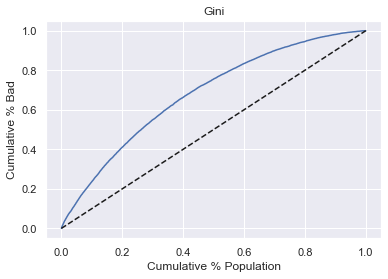

In [33]:
# Plot Gini
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], 
         df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
plt.xlabel('Cumulative % Population')
plt.ylabel('Cumulative % Bad')
plt.title('Gini');

In [34]:
# Calculate Gini from AUROC.
Gini = AUROC * 2 - 1
Gini

0.4044162714201418

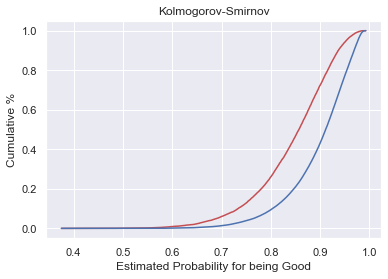

In [35]:
# Plot KS
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
plt.xlabel('Estimated Probability for being Good')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov');

In [36]:
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
KS

0.2966746932223847

<h2><a id="pdmodelapplication">4. Applying the PD Model</a></h2>

[Index](#index)

[4.1 Creating a Scorecard](#pdmodelapplyscorecard)

[4.2 Caclulating Credit Score](#pdmodelapplyscorecalc)

[4.3 From Credit Score to PD](#pdmodelapplyscoretopd)

[4.4 Setting Cut-offs](#pdmodelapplycuoffs)

<h3><a id="pdmodelapplyscorecard">4.1 Creating a Scorecard</a></h3>

[Top](#pdmodelapplication)

In [37]:
# Create an empty df_ref_categories table
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
df_ref_categories['Coefficients'] = 0
df_ref_categories['p_values'] = np.nan
df_ref_categories

,Feature name,Coefficients,p_values
0,grade:G,0,NaN
1,home_ownership:RENT_OTHER_NONE_ANY,0,NaN
2,addr_state:ND_NE_IA_NV_FL_HI_AL,0,NaN
3,verification_status:Verified,0,NaN
4,purpose:educ__sm_b__wedd__ren_en__mov__house,0,NaN
5,initial_list_status:f,0,NaN
6,term:60,0,NaN
7,emp_length:0,0,NaN
8,mths_since_issue_d:>84,0,NaN
9,int_rate:>20.281,0,NaN


In [38]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard = df_scorecard.reset_index()
df_scorecard

,index,Feature name,Coefficients,p_values
0,0,Intercept,-1.374022,NaN
1,1,grade:A,1.123667,3.224492e-35
2,2,grade:B,0.878915,4.281595e-47
3,3,grade:C,0.684794,6.716246e-34
4,4,grade:D,0.496922,1.347121e-20
...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN
98,13,annual_inc:<20K,0.000000,NaN
99,14,dti:>35,0.000000,NaN
100,15,mths_since_last_delinq:0-3,0.000000,NaN


In [39]:
# We create a new column, called 'Original feature name', which contains the value of the 'Feature name' column,
# up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name
0,0,Intercept,-1.374022,NaN,Intercept
1,1,grade:A,1.123667,3.224492e-35,grade
2,2,grade:B,0.878915,4.281595e-47,grade
3,3,grade:C,0.684794,6.716246e-34,grade
4,4,grade:D,0.496922,1.347121e-20,grade
...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq
98,13,annual_inc:<20K,0.000000,NaN,annual_inc
99,14,dti:>35,0.000000,NaN,dti
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq


In [40]:
min_score = 300
max_score = 850

In [41]:
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
df_scorecard.groupby('Original feature name')['Coefficients'].min()

Original feature name
Intercept                     -1.374022
acc_now_delinq                 0.000000
addr_state                     0.000000
annual_inc                    -0.081519
dti                            0.000000
emp_length                     0.000000
grade                          0.000000
home_ownership                 0.000000
initial_list_status            0.000000
inq_last_6mths                 0.000000
int_rate                       0.000000
mths_since_earliest_cr_line    0.000000
mths_since_issue_d            -0.071782
mths_since_last_delinq         0.000000
mths_since_last_record         0.000000
purpose                        0.000000
term                           0.000000
verification_status           -0.011186
Name: Coefficients, dtype: float64

In [42]:
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
min_sum_coef

-1.5385093507973926

In [43]:
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
df_scorecard.groupby('Original feature name')['Coefficients'].max()

Original feature name
Intercept                     -1.374022
acc_now_delinq                 0.180368
addr_state                     0.521966
annual_inc                     0.552379
dti                            0.384448
emp_length                     0.125854
grade                          1.123667
home_ownership                 0.106248
initial_list_status            0.053826
inq_last_6mths                 0.666257
int_rate                       0.883138
mths_since_earliest_cr_line    0.129361
mths_since_issue_d             1.084211
mths_since_last_delinq         0.183090
mths_since_last_record         0.502948
purpose                        0.301859
term                           0.078942
verification_status            0.085717
Name: Coefficients, dtype: float64

In [44]:
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the maximum values.
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
max_sum_coef

5.590259005776147

In [45]:
# We multiply the value of the 'Coefficients' column by the ration of the differences between
# maximum score and minimum score and maximum sum of coefficients and minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef -
                                                                                                min_sum_coef)
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-1.374022,NaN,Intercept,-106.008770
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645
...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000
99,14,dti:>35,0.000000,NaN,dti,0.000000
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000


In [46]:
# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score. 
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) 
                                          / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score

df_scorecard

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-1.374022,NaN,Intercept,312.690576
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645
...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000
99,14,dti:>35,0.000000,NaN,dti,0.000000
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000


In [47]:
# We round the values of the 'Score - Calculation' column.
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,-1.374022,NaN,Intercept,312.690576,313.0
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359,87.0
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233,68.0
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329,53.0
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645,38.0
...,...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000,0.0
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000,0.0
99,14,dti:>35,0.000000,NaN,dti,0.000000,0.0
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000,0.0


In [48]:
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
min_sum_score_prel

300.0

In [49]:
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
max_sum_score_prel

851.0

In [50]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,-1.374022,NaN,Intercept,312.690576,313.0,0.309424
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359,87.0,0.306641
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233,68.0,0.189767
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329,53.0,0.166671
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645,38.0,-0.338645
...,...,...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000,0.0,0.000000
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000,0.0,0.000000
99,14,dti:>35,0.000000,NaN,dti,0.000000,0.0,0.000000
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000,0.0,0.000000


In [51]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard['Score - Final'][77] = 16
df_scorecard

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.374022,NaN,Intercept,312.690576,313.0,0.309424,313.0
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359,87.0,0.306641,87.0
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233,68.0,0.189767,68.0
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329,53.0,0.166671,53.0
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645,38.0,-0.338645,38.0
...,...,...,...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000,0.0,0.000000,0.0
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000,0.0,0.000000,0.0
99,14,dti:>35,0.000000,NaN,dti,0.000000,0.0,0.000000,0.0
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000,0.0,0.000000,0.0


In [52]:
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
min_sum_score_prel

300.0

In [53]:
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
max_sum_score_prel

853.0

<h3><a id="pdmodelapplyscorecalc">4.2 Caclulating Credit Score</a></h3>

[Top](#pdmodelapplication)

In [54]:
inputs_test_with_ref_cat_w_intercept = loan_data_inputs_train[selected_features]
inputs_test_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,...,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
206088,1,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
136020,1,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
412305,1,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
36159,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [55]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,...,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
427211,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
206088,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
136020,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
412305,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36159,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [56]:
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(102, 1)
scorecard_scores.shape

(102, 1)

In [57]:
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)
y_scores.head()

,0
427211,689.0
206088,597.0
136020,671.0
412305,526.0
36159,527.0


<h3><a id="pdmodelapplyscoretopd">4.3 From Credit Score to PD</a></h3>

[Top](#pdmodelapplication)

In [58]:
# We divide the difference between the scores and the minimum score by
# the difference between the maximum score and the minimum score.
# Then, we multiply that by the difference between the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we add the minimum sum of coefficients.
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef

# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)

y_hat_proba_from_score.head()

,0
427211,0.970786
206088,0.909786
136020,0.963391
412305,0.800715
36159,0.802775


<h3><a id="pdmodelapplycuoffs">4.4 Setting Cut-offs</a></h3>

[Top](#pdmodelapplication)

In [59]:
# We need the confusion matrix again.
tr = 0.9
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [60]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
            rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,7374,2816
1,35813,47254


In [61]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
            rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.079072,0.030196
1,0.384025,0.506707


In [62]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
             rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (
    pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
                rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.5857790836076648

In [63]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'],
                                 df_actual_predicted_probs['y_hat_test_proba'])

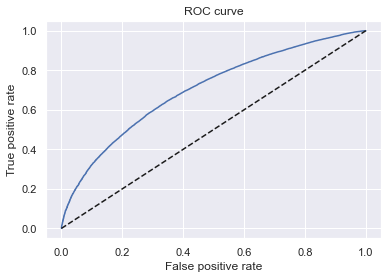

In [64]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [65]:
thresholds

array([1.99262865, 0.99262865, 0.99069771, ..., 0.48790773, 0.3937389 ,
       0.37528625])

In [66]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
# We name the columns of the dataframe 'thresholds', 'fpr', and 'tpr'.
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
df_cutoffs.head()

,thresholds,fpr,tpr
0,1.992629,0.000000,0.000000
1,0.992629,0.000000,0.000012
2,0.990698,0.000000,0.000120
3,0.990653,0.000098,0.000120
4,0.989823,0.000098,0.000421


In [67]:
# Let the first threshold (the value of the thresholds column with index 0) be equal to a number, very close to 1
# but smaller than 1, say 1 - 1 / 10 ^ 16.
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)

# The score corresponsing to each threshold equals:
# The the difference between the natural logarithm of the ratio of the threshold and 1 minus the threshold and
# the minimum sum of coefficients
# multiplied by
# the sum of the minimum score and the ratio of the difference between the maximum score and minimum score and 
# the difference between the maximum sum of coefficients and the minimum sum of coefficients.
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * (
    (max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,2066.0
1,0.992629,0.000000,0.000012,797.0
2,0.990698,0.000000,0.000120,779.0
3,0.990653,0.000098,0.000120,778.0
4,0.989823,0.000098,0.000421,772.0


In [68]:
df_cutoffs['Score'][0] = max_score

In [69]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,850.0
1,0.992629,0.000000,0.000012,797.0
2,0.990698,0.000000,0.000120,779.0
3,0.990653,0.000098,0.000120,778.0
4,0.989823,0.000098,0.000421,772.0


In [70]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, if given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

In [71]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
# Rejection rate equals one minus approval rate.

In [72]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.000000,0.000000,850.0,0,93257,0.000000,1.000000
1,0.992629,0.000000,0.000012,797.0,1,93256,0.000011,0.999989
2,0.990698,0.000000,0.000120,779.0,10,93247,0.000107,0.999893
3,0.990653,0.000098,0.000120,778.0,11,93246,0.000118,0.999882
4,0.989823,0.000098,0.000421,772.0,36,93221,0.000386,0.999614


In [73]:
df_cutoffs.iloc[5000: 6200, ]
# Here we display the dataframe with cutoffs form line with index 5000 to line with index 6200.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5000,0.903546,0.259568,0.547919,591.0,48159,45098,0.516412,0.483588
5001,0.903509,0.259568,0.548148,591.0,48178,45079,0.516615,0.483385
5002,0.903508,0.259666,0.548148,591.0,48179,45078,0.516626,0.483374
5003,0.903481,0.259666,0.548316,591.0,48193,45064,0.516776,0.483224
5004,0.903481,0.259764,0.548316,591.0,48194,45063,0.516787,0.483213
...,...,...,...,...,...,...,...,...
6195,0.890488,0.324632,0.620499,580.0,54851,38406,0.588170,0.411830
6196,0.890486,0.324730,0.620499,580.0,54852,38405,0.588181,0.411819
6197,0.890464,0.324730,0.620607,580.0,54861,38396,0.588278,0.411722
6198,0.890463,0.324828,0.620607,580.0,54862,38395,0.588288,0.411712


In [74]:
df_cutoffs.iloc[1000: 2000, ]
# Here we display the dataframe with cutoffs form line with index 1000 to line with index 2000.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
1000,0.953241,0.049166,0.206592,651.0,17662,75595,0.189391,0.810609
1001,0.953230,0.049166,0.206737,651.0,17674,75583,0.189519,0.810481
1002,0.953226,0.049264,0.206737,651.0,17675,75582,0.189530,0.810470
1003,0.953219,0.049264,0.206809,651.0,17681,75576,0.189594,0.810406
1004,0.953219,0.049362,0.206809,651.0,17682,75575,0.189605,0.810395
...,...,...,...,...,...,...,...,...
1995,0.936789,0.100294,0.322860,627.0,27841,65416,0.298541,0.701459
1996,0.936788,0.100393,0.322860,627.0,27842,65415,0.298551,0.701449
1997,0.936754,0.100393,0.323077,627.0,27860,65397,0.298744,0.701256
1998,0.936754,0.100491,0.323077,627.0,27861,65396,0.298755,0.701245


In [75]:
inputs_train_with_ref_cat = loan_data_inputs_train[selected_features]
inputs_train_with_ref_cat.to_csv('..//Data//inputs_train_with_ref_cat.csv')

In [76]:
df_scorecard.to_csv('../Data/df_scorecard.csv')